In [1]:
library(ggplot2)
library(data.table)
library(dplyr)
library(arules)
library(rpart)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix

Attaching package: ‘arules’

The following object is masked from ‘package:dplyr’:

    recode

The following objects are masked from ‘package:base’:

    abbreviate, write



In [2]:
dt <- fread("train/train.csv", stringsAsFactor=T)

Antes de mais nada, conforme mencionado em **Parte_1**, algumas instâncias da tabela estão incompletas. Aquelas instâncias que possuem poucos elementos faltantes serão eliminadas.

In [3]:
dt <- dt[SexuponOutcome != '']
dt <- dt[AgeuponOutcome != '']

In [6]:
dt2 <- dt
dt2$Name <- NULL
dt2$DateTime <- NULL
dt2$OutcomeType <- NULL
dt2$OutcomeSubtype <- NULL
dt2$AnimalType <- NULL
dt2$SexuponOutcome <- NULL
dt2$AgeuponOutcome <- NULL
dt2$Breed <- NULL
dt2$Color <- NULL

In [7]:
transformacao.linear <- function (x){
    new.x <- (x - min(x)) / (max(x)-min(x))
    new.x
}

mapeamento <- function (x1, x2, y) {
    mapped <- y[match(x1, x2)]
    mapped
}

## Transformando os Dados

Nesta parte, cada atributo será transformado, e estes novos valores substituirão os valores antigos,
para salvar a tabela concluída em um novo arquivo.

### SexuponOutcome

Visualizando os dados.

In [5]:
options(repr.plot.width=9, repr.plot.height=3)
outcomes <- dt[1:length(dt$Name),] %>%
group_by(SexuponOutcome, OutcomeType) %>%
summarise(frequency = n())
ggplot(outcomes, aes(x = SexuponOutcome, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Como este atributo possui duas informações, será quebrado em dois novos atributos. Primeiro, o atributo Sex, que será 0 para fêmeas, 1 para machos e -1 para desconhecido.

In [8]:
dt2$Sex <- ifelse(dt$SexuponOutcome == 'Neutered Male', 1,
               ifelse(dt$SexuponOutcome == 'Intact Male', 1, 
                     ifelse(dt$SexuponOutcome == 'Unknown', -1, 0)))

In [9]:
dt2$AnimalID <- NULL

Agora, um segundo atributo será criado, indicando se o animal foi castrado, independentemente de ser macho ou fêmea, ou se não foi castrado ou não é sabido.

In [10]:
dt2$Castrated <- ifelse(dt$SexuponOutcome == 'Intact Male', 0,
                  ifelse(dt$SexuponOutcome == 'Intact Female', 0,
                         ifelse(dt$SexuponOutcome == 'Unknown', -1, 1)))

### AgeuponOutcome

Este atributo será transformado, para conter apenas uma única informação, na medida de dias.

In [11]:
age_upon <- data.table(AgeuponOutcome = dt$AgeuponOutcome)
age_upon <- age_upon[, c("Numero","Unidade") := tstrsplit(AgeuponOutcome," ",fixed=T)]

In [12]:
age_upon$Unidade <- gsub("year(\\w?)" ,"365", age_upon$Unidade )
age_upon$Unidade <- gsub("month(\\w?)","30",  age_upon$Unidade )
age_upon$Unidade <- gsub("week(\\w?)" ,"7",   age_upon$Unidade )
age_upon$Unidade <- gsub("day(\\w?)"  ,"1",   age_upon$Unidade )
age_upon$Unidade <- gsub("^$"         ,NA ,   age_upon$Unidade )

In [13]:
age_upon$Numero <- as.numeric(age_upon$Numero)
age_upon$Unidade <- as.numeric(age_upon$Unidade)
age_upon$DaysuponOutcome <- age_upon$Numero * age_upon$Unidade

Visualizando os dados, de forma normalizada e ordenada para uma melhor visualização.

In [14]:
options(repr.plot.width=9, repr.plot.height=5)
ggplot(age_upon, aes(x=DaysuponOutcome)) + geom_histogram(bins=20) + scale_x_log10()

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 22 rows containing non-finite values (stat_bin).”

- Como existem muitas classes, isto poderá trazer um efeito negativo no modelo, pois isto poderá ter um
comportamento semelhante ao do ID do animal, onde a entropia é baixa mas não há um bom agrupamento com várias instâncias. Por isso, os dados serão agrupados por uma técnica de discretização.
- Optou-se neste trabalho por agrupar os animais, arbritrariamente, conforme a faixa etária. O gráfico abaixo demonstra como que as classes de faixa etária dividem os dados.

In [15]:
dt$AgerangeuponOutcome <- ifelse(age_upon$DaysuponOutcome < 360, 'Baby',
                                 ifelse(age_upon$DaysuponOutcome < 1080, 'Teenager',
                                        ifelse(age_upon$DaysuponOutcome < 2520, 'Adult', 'Ancient')))

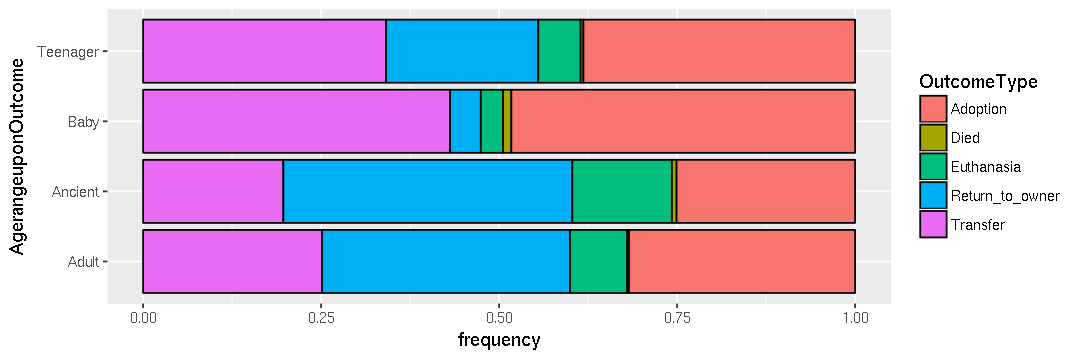

In [16]:
options(repr.plot.width=9, repr.plot.height=3)
outcomes <- dt[1:length(dt$Name),] %>%
group_by(AgerangeuponOutcome, OutcomeType) %>%
summarise(frequency = n())
ggplot(outcomes, aes(x = AgerangeuponOutcome, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Como pode ser visto no gráfico, a maioria dos animais que retornam para o donatário são os animais anciões. O que mais frequentemente ocorre com os bebês são a transferência ou a adoção. Como pode ser visto, este agrupamento consegue separar os dados, por isto estes valores serão utilizados como entrada para o modelo.
Como a base conterá apenas valores numéricos, este novo atributo possui como classes os valores do intervalo [-1;1]

In [17]:
dt2$AgerangeuponOutcome <- ifelse(age_upon$DaysuponOutcome < 360, -1,
                                 ifelse(age_upon$DaysuponOutcome < 1080, -0.3,
                                        ifelse(age_upon$DaysuponOutcome < 2520, 0.3, 1)))

### Breed

Este atributo possui duas informações: a raça do animal e se ele é de raça pura ou mestiço. Por isso, este atributo será separado em dois.

Aqui, será analisado se a raça é pura ou não.

In [18]:
Mix <- ifelse(grepl('Mix', dt$Breed), 1,
             ifelse(grepl('/', dt$Breed), 1, 0))

Aqui será retirado a informação sobre a raça ser pura ou não. Em seguida, como ainda restarão muitas raças,
elas serão agrupadas. Por fim, os dados categóricos serão transformados em dados numéricos.

In [19]:
breeds <- dt2
breeds$Sex <- NULL
breeds$AnimalType <- dt$AnimalType
breeds$Castrated <- NULL

Retirando a informação sobre a raça ser mista.

In [20]:
aux <- gsub(" Mix", "", dt$Breed)
breeds$breed <- strsplit(x = aux, split = "/") %>% sapply(function(x){x[1]})

Criando duas colunas, para poder diferenciar o que é raça de cão do que é raça de gato. Da forma como foi implementado, na coluna **dogs** toda raça de gato aparecerá como NA, e vice-versa

In [21]:
breeds$dogs <- ifelse(breeds$AnimalType == 'Dog', breeds$breed, NA)
breeds$cats <- ifelse(breeds$AnimalType == 'Cat', breeds$breed, NA)
breeds$OutcomeType <- dt$OutcomeType

In [22]:
outcomes <- breeds[1:length(breeds$dogs),] %>%
group_by(dogs, OutcomeType) %>%
summarise(frequency = n())

Avaliando a distribuição de das classes de OutcomType entre cada classe de Breed, filtrado pelo animal ser do tipo Dog

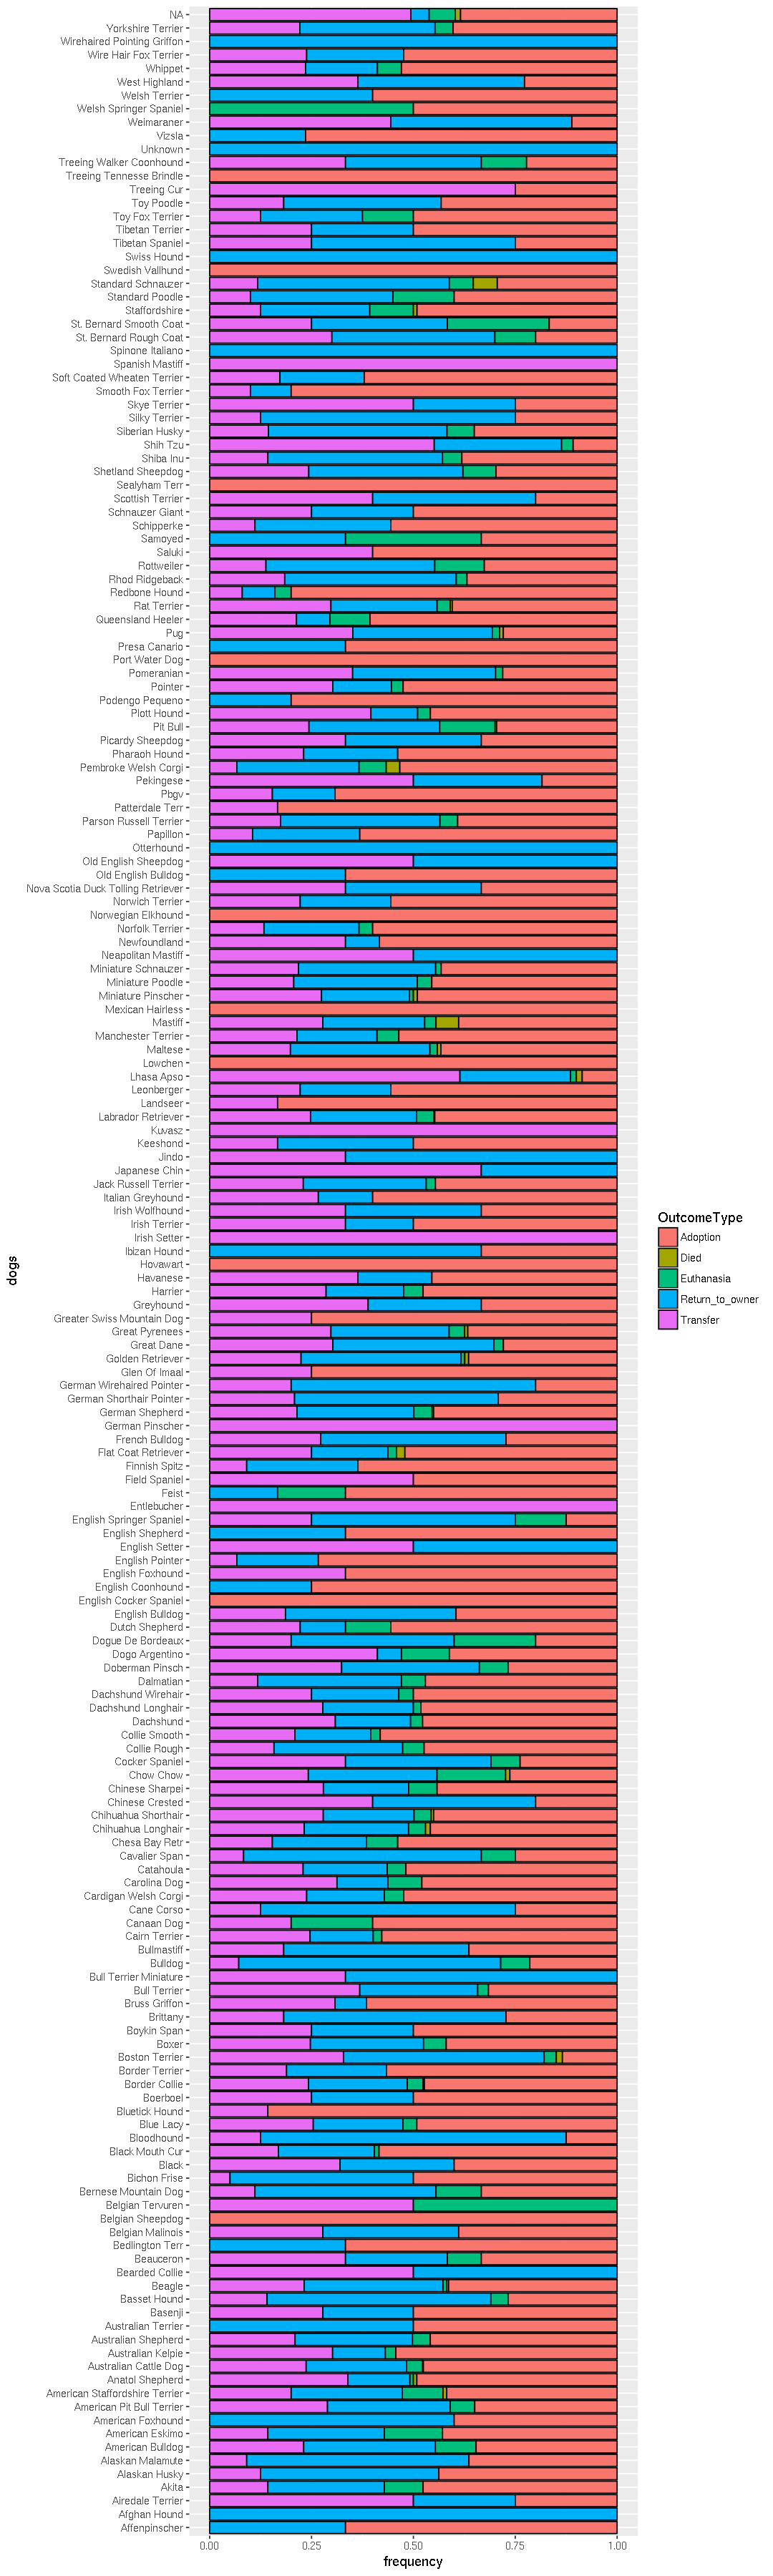

In [23]:
options(repr.plot.width=9, repr.plot.height=30)
ggplot(outcomes, aes(x = dogs, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Por fim, descobrindo quais são as raças de cães mais populares, por meio de uma filtragem. Aquelas raças que possuem uma frequência menor que 150, serão agrupadas.

In [24]:
count(breeds, dogs) %>%
    arrange(desc(n)) %>%
    filter(n >150) -> popular

breeds$dogs[!(breeds$dogs %in% popular$dogs)] <- "exotic_dog"
head(breeds, 20)

AgerangeuponOutcome AnimalType breed                     dogs               
1  -0.3                Dog        Shetland Sheepdog         exotic_dog         
2  -0.3                Cat        Domestic Shorthair        NA                 
3  -0.3                Dog        Pit Bull                  Pit Bull           
4  -1.0                Cat        Domestic Shorthair        NA                 
5  -0.3                Dog        Lhasa Apso                exotic_dog         
6  -1.0                Dog        Cairn Terrier             exotic_dog         
7  -1.0                Cat        Domestic Shorthair        NA                 
8  -1.0                Cat        Domestic Shorthair        NA                 
9  -1.0                Dog        American Pit Bull Terrier exotic_dog         
10 -0.3                Dog        Cairn Terrier             exotic_dog         
11 -0.3                Cat        Domestic Shorthair        NA                 
12 -0.3                Dog        Miniature Schnauzer       Miniature Schnauzer
13  0.3                Dog        Pit Bull                  Pit Bull           
14 -0.3                Dog        Yorkshire Terrier         Yorkshire Terrier  
15 -0.3                Dog        Great Pyrenees            exotic_dog         
16 -1.0                Cat        Domestic Shorthair        NA                 
17 -1.0                Cat        Domestic Shorthair        NA                 
18 -1.0                Dog        Pit Bull                  Pit Bull           
19 -0.3                Cat        Angora                    NA                 
20 -0.3                Dog        Flat Coat Retriever       exotic_dog         
   cats               OutcomeType    
1  NA                 Return_to_owner
2  Domestic Shorthair Euthanasia     
3  NA                 Adoption       
4  Domestic Shorthair Transfer       
5  NA                 Transfer       
6  NA                 Transfer       
7  Domestic Shorthair Transfer       
8  Domestic Shorthair Transfer       
9  NA                 Adoption       
10 NA                 Adoption       
11 Domestic Shorthair Transfer       
12 NA                 Adoption       
13 NA                 Adoption       
14 NA                 Return_to_owner
15 NA                 Return_to_owner
16 Domestic Shorthair Adoption       
17 Domestic Shorthair Transfer       
18 NA                 Transfer       
19 Angora             Transfer       
20 NA                 Return_to_owner

Avaliando a distribuição de das classes de OutcomType entre cada classe de Breed, filtrado pelo animal ser do tipo Cat

In [25]:
outcomes <- breeds[1:length(breeds$cats),] %>%
group_by(cats, OutcomeType) %>%
summarise(frequency = n())

In [26]:
options(repr.plot.width=9, repr.plot.height=15)
ggplot(outcomes, aes(x = cats, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Por fim, descobrindo quais são as raças de gatos mais populares, por meio de uma filtragem. Aquelas raças que possuem uma frequência menor que 100, serão agrupadas.

In [27]:
count(breeds, cats) %>%
    arrange(desc(n)) %>%
    filter(n >100) -> popular

breeds$cats[!(breeds$cats %in% popular$cats)] <- "exotic_cat"
head(breeds, 20)

AgerangeuponOutcome AnimalType breed                     dogs               
1  -0.3                Dog        Shetland Sheepdog         exotic_dog         
2  -0.3                Cat        Domestic Shorthair        NA                 
3  -0.3                Dog        Pit Bull                  Pit Bull           
4  -1.0                Cat        Domestic Shorthair        NA                 
5  -0.3                Dog        Lhasa Apso                exotic_dog         
6  -1.0                Dog        Cairn Terrier             exotic_dog         
7  -1.0                Cat        Domestic Shorthair        NA                 
8  -1.0                Cat        Domestic Shorthair        NA                 
9  -1.0                Dog        American Pit Bull Terrier exotic_dog         
10 -0.3                Dog        Cairn Terrier             exotic_dog         
11 -0.3                Cat        Domestic Shorthair        NA                 
12 -0.3                Dog        Miniature Schnauzer       Miniature Schnauzer
13  0.3                Dog        Pit Bull                  Pit Bull           
14 -0.3                Dog        Yorkshire Terrier         Yorkshire Terrier  
15 -0.3                Dog        Great Pyrenees            exotic_dog         
16 -1.0                Cat        Domestic Shorthair        NA                 
17 -1.0                Cat        Domestic Shorthair        NA                 
18 -1.0                Dog        Pit Bull                  Pit Bull           
19 -0.3                Cat        Angora                    NA                 
20 -0.3                Dog        Flat Coat Retriever       exotic_dog         
   cats               OutcomeType    
1  NA                 Return_to_owner
2  Domestic Shorthair Euthanasia     
3  NA                 Adoption       
4  Domestic Shorthair Transfer       
5  NA                 Transfer       
6  NA                 Transfer       
7  Domestic Shorthair Transfer       
8  Domestic Shorthair Transfer       
9  NA                 Adoption       
10 NA                 Adoption       
11 Domestic Shorthair Transfer       
12 NA                 Adoption       
13 NA                 Adoption       
14 NA                 Return_to_owner
15 NA                 Return_to_owner
16 Domestic Shorthair Adoption       
17 Domestic Shorthair Transfer       
18 NA                 Transfer       
19 exotic_cat         Transfer       
20 NA                 Return_to_owner

Agora sim, as raças serão construídas em **dt2**. Somente as raças mais populares de cães e gatos permanecerão, enquanto que as impopulares foram agrupadas.

In [28]:
Unified_Breed <- ifelse(breeds$AnimalType == 'Dog', breeds$dogs, breeds$cats)

In [29]:
classes <- unique(Unified_Breed)
numeric_classes <- c(1:length(classes))
normalized_classes <- transformacao.linear(numeric_classes)
dt2$Breed <- mapeamento(Unified_Breed, classes, normalized_classes)

In [30]:
dt2$Mix_Breed <- Mix

### AnimalType

Aqui será simples, basta transformar os dados categóricos para numéricos. Se for um cão, será 1. Se for um gato, será 0.

In [31]:
dt2$AnimalType <- ifelse(dt$AnimalType == 'Dog', 1, 0)

### OutcomeType

Vamos visualizar como ficou no final **dt2**

In [32]:
head(dt2, 30)

Sex Castrated AgerangeuponOutcome Breed Mix_Breed AnimalType
1   1   1        -0.3                0.00  1         1         
2   0   1        -0.3                0.04  1         0         
3   1   1        -0.3                0.08  1         1         
4   1   0        -1.0                0.04  1         0         
5   1   1        -0.3                0.00  1         1         
6   0   0        -1.0                0.00  1         1         
7   1   0        -1.0                0.04  1         0         
8  -1  -1        -1.0                0.04  1         0         
9   0   1        -1.0                0.00  1         1         
10  0   1        -0.3                0.00  0         1         
11 -1  -1        -0.3                0.04  1         0         
12  0   1        -0.3                0.12  1         1         
13  1   1         0.3                0.08  1         1         
14  1   1        -0.3                0.16  1         1         
15  1   1        -0.3                0.00  1         1         
16  1   1        -1.0                0.04  1         0         
17  1   0        -1.0                0.04  1         0         
18  0   0        -1.0                0.08  1         1         
19  0   0        -0.3                0.20  1         0         
20  1   1        -0.3                0.00  1         1         
21  1   0        -1.0                0.00  1         1         
22  0   1        -0.3                0.04  1         0         
23  0   1        -0.3                0.00  1         1         
24  1   1        -1.0                0.24  1         1         
25  1   1        -1.0                0.24  1         1         
26  0   0        -1.0                0.04  1         0         
27  0   1        -1.0                0.00  1         1         
28  0   1         0.3                0.28  1         1         
29  0   1        -1.0                0.04  1         0         
30  1   1         1.0                0.20  1         0

Como serão utilizados dois modelos preditores diferentes, SVM e ANN, deveremos construir duas base de dados diferentes. Uma, contendo um único atributo com as classes, para o SVM, e outra, contendo cada classe de OutcomeType como sendo um atributo binário diferente, a forma mais apropriada de se criar saídas para uma ANN.

In [33]:
dt3 <- dt2

In [34]:
dt4 <- dt2

In [35]:
classes <- unique(dt$OutcomeType)
numeric_classes <- c(1:length(classes))
dt2$OutcomeType <- mapeamento(dt$OutcomeType, classes, numeric_classes)

In [36]:
head(classes, 10)

[1] Return_to_owner Euthanasia      Adoption        Transfer       
[5] Died           
Levels: Adoption Died Euthanasia Return_to_owner Transfer

In [37]:
dt3$OT1 <- ifelse(dt$OutcomeType == 'Return_to_owner', 1, 0)
dt3$OT2 <- ifelse(dt$OutcomeType == 'Euthanasia', 1, 0)
dt3$OT3 <- ifelse(dt$OutcomeType == 'Adoption', 1, 0)
dt3$OT4 <- ifelse(dt$OutcomeType == 'Transfer', 1, 0)
dt3$OT5 <- ifelse(dt$OutcomeType == 'Died', 1, 0)

In [38]:
dt4$OutcomeType <- dt$OutcomeType

Por fim, vamos salvar estas duas base de dados em tabelas.

In [39]:
write.csv(dt2, "train/Train_SVM.csv")

In [40]:
write.csv(dt3, "train/Train_ANN.csv")

In [42]:
write.csv(dt4, "train/Train_Classificator.csv")